In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.summarization.bm25 import get_bm25_weights
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords 
import sklearn
import math
from sklearn.cluster import KMeans

# Fetching Data

In [3]:
data = pd.read_csv("heena_drama.csv")

In [23]:
# viewing data example to know how our data actually lools like
data.head()

,article_id,article_text
0,NaN,In Drama every world is a stage.
1,NaN,Everyone on the stage is doing drama .
2,NaN,Every world is a stage and is commonly said i...
3,NaN,The world commonly revolves around Drama and S...
4,NaN,Drama in every world leads to removal of stage...


In [24]:
s

NameError: name 's' is not defined

In [56]:
#splitting the documents into list of sentences.
sentences = [] 
for s in data['article_text']:
    sentences.append(sent_tokenize(s))
sentences = [[y] for x in sentences for y in x] # flatten list

In [60]:
a=["my name is jatin keswani","jatin is very good at football"]
sentences=a
sentences = [[x] for x in sentences] # flatten list

In [61]:
sentences

[['my name is jatin keswani'], ['jatin is very good at football']]

In [67]:
sentences[:5]
# np.shape(sentences)

[['my name is jatin keswani'], ['jatin is very good at football']]

In [68]:
word_sentence=[]
for i in sentences:
    for j in i:
        word_sentence.append(word_tokenize(j))
word_sentence

[['my', 'name', 'is', 'jatin', 'keswani'],
 ['jatin', 'is', 'very', 'good', 'at', 'football']]

In [69]:
#removal of stop words
stop_words = set(stopwords.words('english')) 
line=[]
filtered_sentence=[]

for i in word_sentence:
    for j in i:
        if not j in stop_words:
            line.append(j)
    filtered_sentence.append(line)
    line=[]



In [70]:
filtered_sentence

[['jatin', 'keswani'], ['jatin', 'good', 'football']]

In [71]:
#stemming the words
from nltk.stem import PorterStemmer 
ps = PorterStemmer()
stemmed_sentences=[]
line=[]
for i in filtered_sentence:
    for j in i:
       line.append(ps.stem(j))
    stemmed_sentences.append(line)
    line=[]

In [72]:
stemmed_sentences

[['jatin', 'keswani'], ['jatin', 'good', 'footbal']]

In [73]:
# remove punctuations, numbers and special characters
alphabetic_sentences=[]
line=[]
for i in stemmed_sentences:
    line.append(pd.Series(i).str.replace("[^a-zA-Z]", " "))
    
    
    alphabetic_sentences.append(line)
    line=[]

In [74]:
line = []

for i in alphabetic_sentences:
   
    for j in i:
        l=[]
        for x in j.values:
            if not x ==' ':
                l.append(x.lower())
        line.append(l)
line

[['jatin', 'keswani'], ['jatin', 'good', 'footbal']]

In [81]:
(line)=word_sentence
line

[['my', 'name', 'is', 'jatin', 'keswani'],
 ['jatin', 'is', 'very', 'good', 'at', 'football']]

In [98]:
words=[]
words=[y for x in line for y in x ]

#Taking all distinct words in an array
Distinct_Words=[y for y in set(words)]

In [99]:
Distinct_Words

['football', 'keswani', 'name', 'good', 'at', 'my', 'jatin', 'is', 'very']

In [100]:
(words)

['my',
 'name',
 'is',
 'jatin',
 'keswani',
 'jatin',
 'is',
 'very',
 'good',
 'at',
 'football']

In [101]:
len(line)

2

## Visualizing Data

In [102]:
for i in range(len(Distinct_Words)):
    print (i,Distinct_Words[i])
    

0 football
1 keswani
2 name
3 good
4 at
5 my
6 jatin
7 is
8 very


In [103]:
word_occurance_matrix=np.empty(shape=(len(line),len(Distinct_Words)))
word_occurance_matrix.fill(0)

In [104]:
for i in range(len(line)):
    for j in range(len(line[i])):
        for x in range(len(Distinct_Words)):
            if (Distinct_Words[x]==line[i][j]):
                word_occurance_matrix[i][x] = word_occurance_matrix[i][x] +1
                continue

In [105]:
print(word_occurance_matrix)

[[0. 1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 1.]]


# okapi BM25

In [106]:
word_weight_matrix=np.empty(shape=(len(line),len(Distinct_Words)))
word_weight_matrix.fill(0)
    
    
avg_length=np.mean(word_occurance_matrix.sum(axis=1))
    
length_size=np.array(1.5*word_occurance_matrix.sum(axis=1)/avg_length)
    
    
    
isf=np.array(np.log(len(line)/np.count_nonzero(word_occurance_matrix,axis=0)))
denominator=np.empty(shape=(len(line),len(Distinct_Words)))
for i in range(len(line)):
    denominator[i,:]=(word_occurance_matrix[i,:]+length_size[i]+0.5)
    
word_weight_matrix=(word_occurance_matrix*isf)/(denominator)
word_weight_matrix    

array([[0.        , 0.2420514 , 0.2420514 , 0.        , 0.        ,
        0.2420514 , 0.        , 0.        , 0.        ],
       [0.22100345, 0.        , 0.        , 0.22100345, 0.22100345,
        0.        , 0.        , 0.        , 0.22100345]])

# RNN Similarity measure 

In [25]:
sum_weights=np.sum(word_weight_matrix,axis=1)

product_weight=np.empty(shape=(len(line),len(line)))
for i in range(len(line)):
    for j in range(len(line)):
        product_weight[i][j]=sum(word_weight_matrix[i,:]*word_weight_matrix[j,:])
product_weight
similarity_matrix=np.empty(shape=np.shape(product_weight))

In [26]:
for i in range(len(line)):
    for j in range(len(line)):
        similarity_matrix[i,j]= 1-((2*(sum_weights[i] - product_weight[i,j])*(sum_weights[j] - product_weight[i,j]))/((sum_weights[i]*(sum_weights[j] - product_weight[i,j])) + (sum_weights[j]*(sum_weights[i] - product_weight[i,j]))))
similarity_matrix

array([[0.96838753, 0.29848062, 0.35188631, ..., 0.        , 0.        ,
        0.        ],
       [0.29848062, 1.34831712, 0.24808986, ..., 0.        , 0.        ,
        0.        ],
       [0.35188631, 0.24808986, 1.00663851, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.94521695, 0.11106535,
        0.21074395],
       [0.        , 0.        , 0.        , ..., 0.11106535, 1.00416823,
        0.02479557],
       [0.        , 0.        , 0.        , ..., 0.21074395, 0.02479557,
        0.67670431]])

In [59]:
i=np.argsort(word_weight_matrix, axis=1)

print((np.max(word_weight_matrix[32:],axis=1)))

[2.00370927 1.22638376 1.37894824 1.00418182 1.22638376 1.19220717
 0.85862135]


In [52]:
np.shape(i)

(39, 162)

TypeError: find_common_type() missing 1 required positional argument: 'scalar_types'

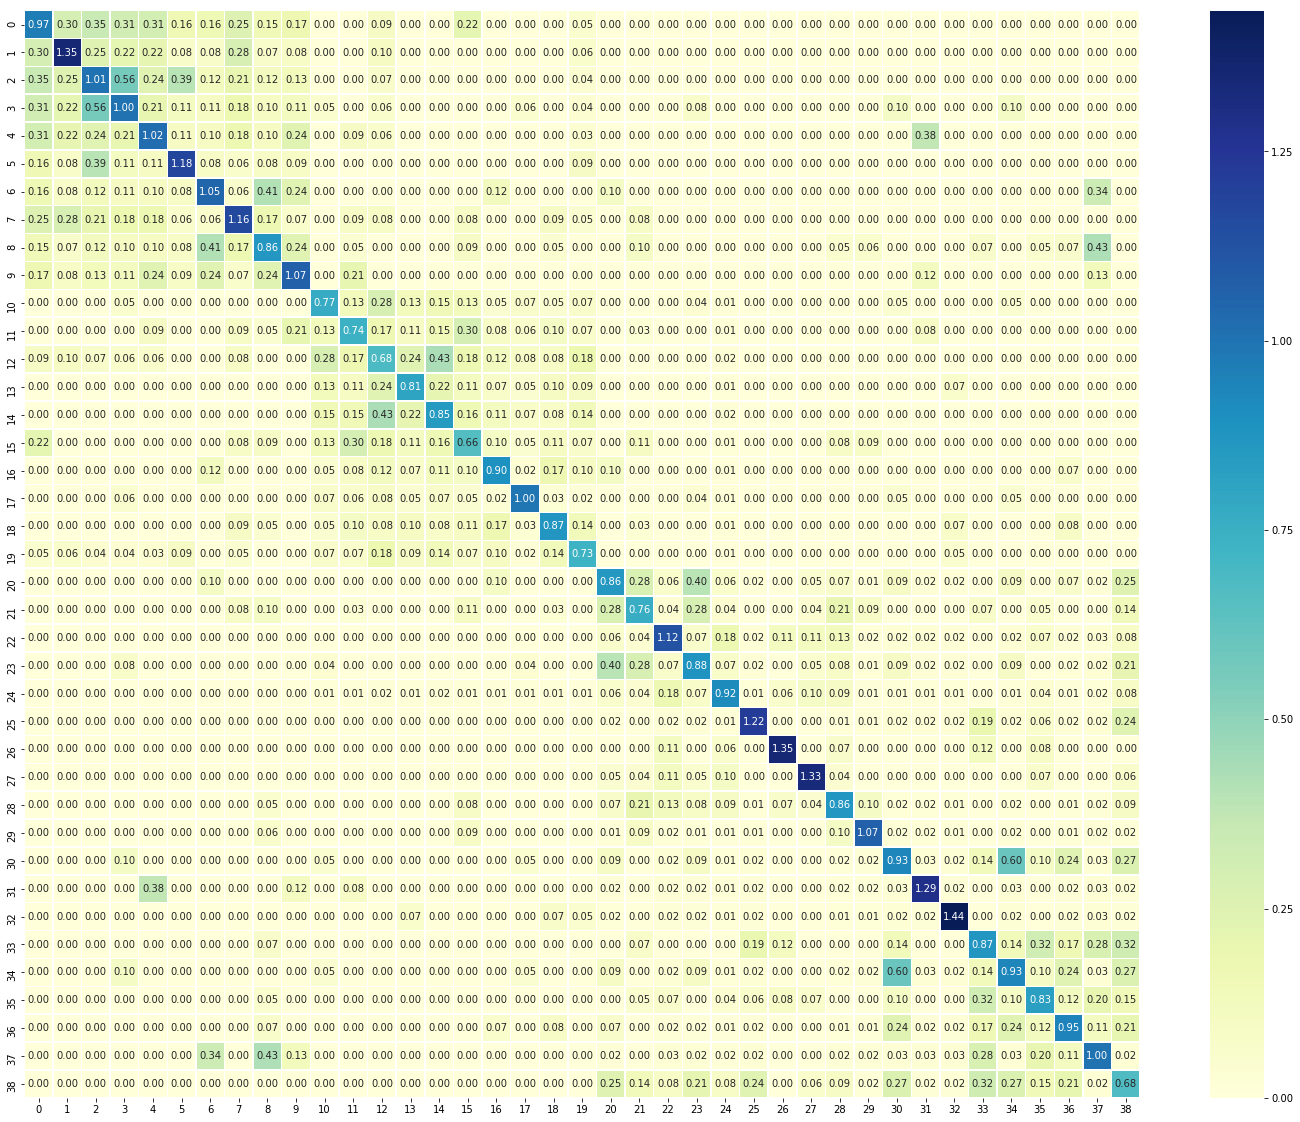

In [28]:
f,ax = plt.subplots(figsize=(25, 20))
sns.heatmap(similarity_matrix, annot=True, linewidths=.5, fmt= '.2f', cmap="YlGnBu")

plt.show()

In [29]:
distance_matrix=np.max(similarity_matrix)-similarity_matrix

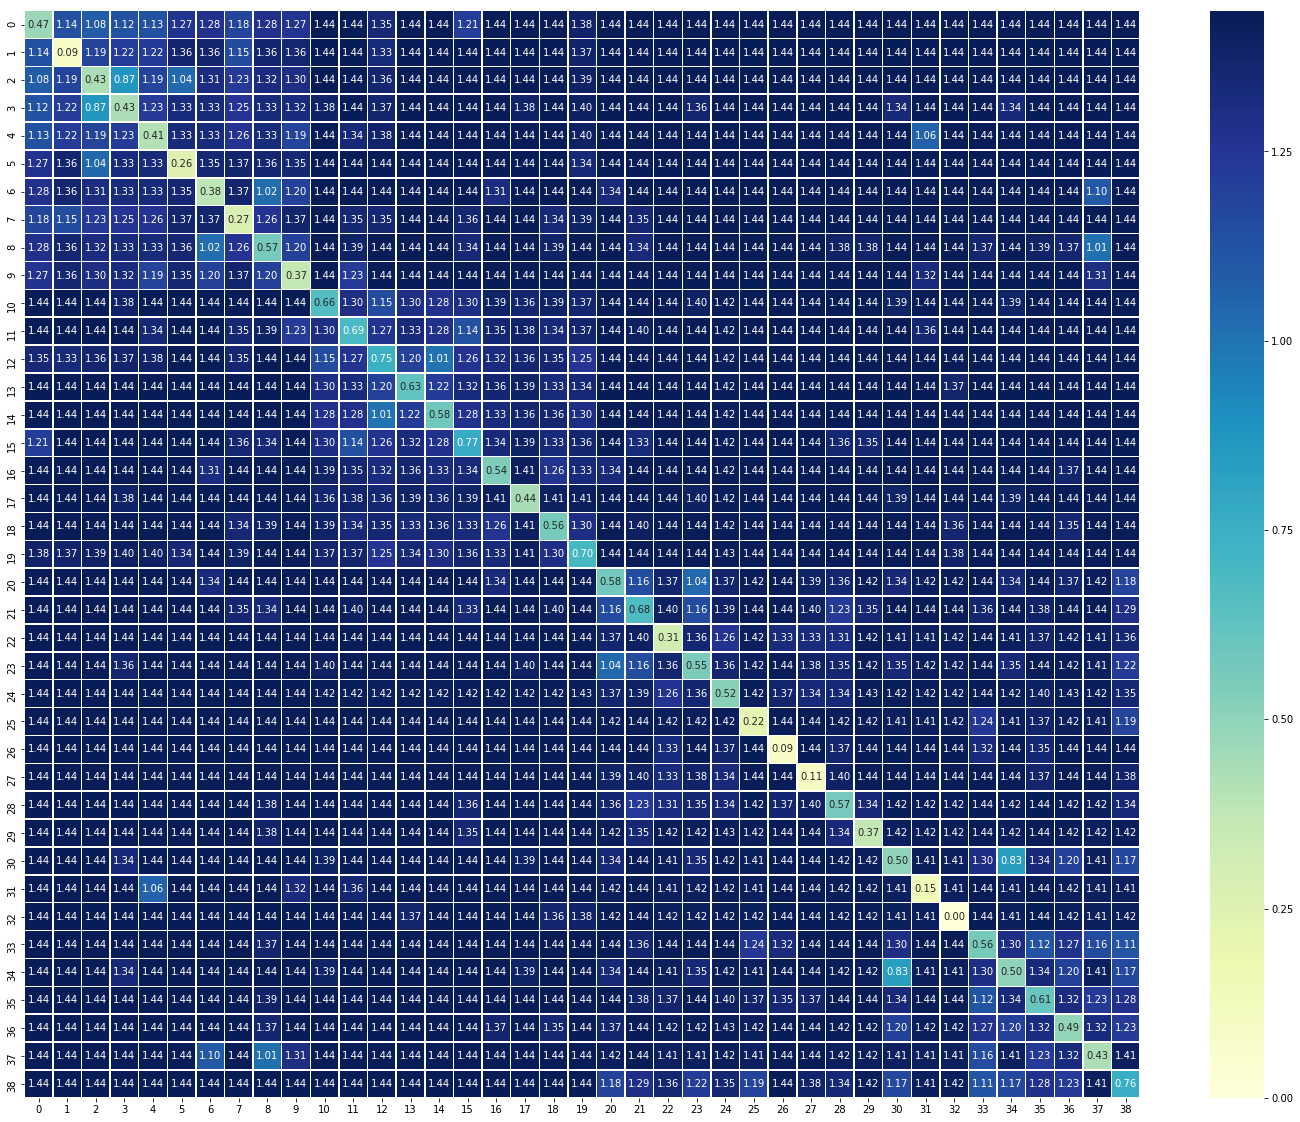

In [30]:
f,ax = plt.subplots(figsize=(25, 20))
sns.heatmap(distance_matrix, annot=True, linewidths=.5, fmt= '.2f', cmap="YlGnBu")

plt.show()

## Clustering

### K-Medoids

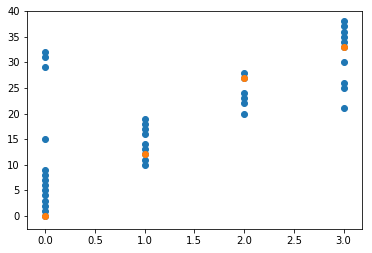

In [222]:
from pyclustering.cluster import kmedoids
import random

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

##############################################################################################################################

matrix = distance_matrix
M, C = kMedoids(matrix, 4)

a=np.empty(shape=len(line))
for i in range(len(C)):
    for j in (C[i]):
        a[j]=i
    
#print(a)
arr = np.empty(shape=len(line))
for i in range(len(line)):
    arr[i]=i
m=[0,1,2,3]

#plt.figure(figsize=(15,10))
plt.scatter(a, arr)
plt.scatter(m,M)

### K-Means

[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 1 3 3 1 1 1 1
 2 1]


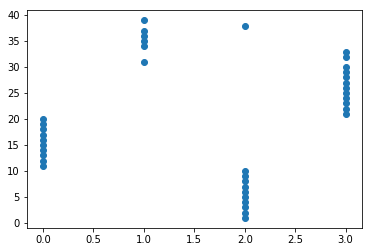

In [211]:
mat = distance_matrix

kmeans = KMeans(n_clusters=4, init='k-means++').fit_predict(mat)
print(kmeans)
arr = [1, 2, 3 ,4, 5 , 6, 7, 8, 9, 10, 11 , 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,39]

#plt.figure(figsize=(15,10))
plt.scatter(kmeans, arr)